In [ ]:
import tensorflow as tf
IMG_HEIGHT= 224
IMG_WIDTH= 224
IMG_CHANNELS=3
CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

In [ ]:
def read_and_decode(filename, resize_dims):
  # 1. Read the raw file
  img_bytes= tf.io.read_file(filename)
  # 2. Decode image data
  img= tf.image.decode_jpeg(img_bytes, channels=IMG_CHANNELS)
  # 3. Convert image to float values in [0, 1]
  img= tf.image.convert_image_dtype(img, tf.float32)
  # 4. Resize the image to the match the desire dimention
  img= tf.image.resize(img, resize_dims)
  return img


In [ ]:
def parse_csvline(csv_line):
  # print("csv line:", csv_line)
  # record_defaults specify the data types for each columns
  record_default = ["", ""]
  filename, label_string =tf.io.decode_csv(csv_line, record_defaults=record_default)


  #load the image
  img= read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  # print("Label String:",label_string)
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

#This csv file conatains the path of the image and its corresponding label, It is stored on the Google Cloud Storage

In [ ]:
!gsutil cat gs://cloud-ml-data/img/flower_photos/train_set.csv | head

gs://cloud-ml-data/img/flower_photos/daisy/754296579_30a9ae018c_n.jpg,daisy
gs://cloud-ml-data/img/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/dandelion/284497199_93a01f48f6.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/daisy/4065883015_4bb6010cb7_n.jpg,daisy
gs://cloud-ml-data/img/flower_photos/roses/7420699022_60fa574524_m.jpg,roses
gs://cloud-ml-data/img/flower_photos/dandelion/4558536575_d43a611bd4_n.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/daisy/7568630428_8cf0fc16ff_n.jpg,daisy
gs://cloud-ml-data/img/flower_photos/tulips/7064813645_f7f48fb527.jpg,tulips
gs://cloud-ml-data/img/flower_photos/sunflowers/4933229095_f7e4218b28.jpg,sunflowers


In [ ]:
#Define dataset
train_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
    #.map(parse_csvline) # it will process one by one line to the map function which is slow
    #.map(parse_csvline, num_parallel_calls=4) # it will process one by four line to the map function which is faster

    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE) # It will adjust the number of line to the function depends upon the cpu
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)
test_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE) # When the model is training the current batch then it will prepare the next batch in the background.
)

In [ ]:
for image_batch, label_batch in train_dataset.take(3):
  print("Image Batch Shape: ", image_batch.shape)
  print("Label Batch Shape: ", label_batch.shape)
  print("Labels:", label_batch.numpy())




Image Batch Shape:  (16, 224, 224, 3)
Label Batch Shape:  (16,)
Labels: [0 1 1 1 0 2 1 0 4 3 0 3 1 4 4 1]
Image Batch Shape:  (16, 224, 224, 3)
Label Batch Shape:  (16,)
Labels: [0 3 2 1 0 4 2 0 2 2 1 3 3 2 1 0]
Image Batch Shape:  (16, 224, 224, 3)
Label Batch Shape:  (16,)
Labels: [3 1 1 1 1 0 1 2 4 3 3 2 0 1 4 0]


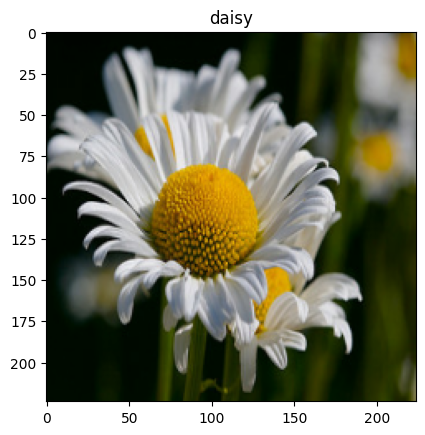

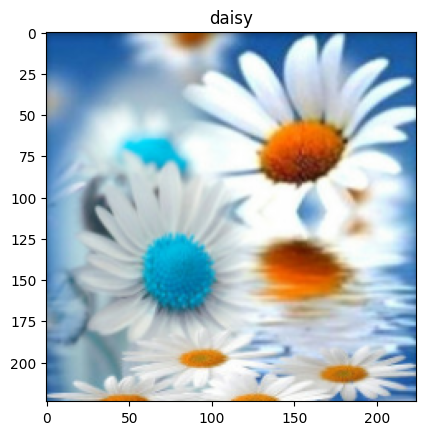

In [ ]:
import matplotlib.pyplot as plt
for image_batch, label_batch in train_dataset.take(2):
  first_image=image_batch[0].numpy()
  first_label=label_batch[0].numpy()
  plt.imshow(first_image)
  plt.title(CLASS_NAMES[first_label])
  plt.show()


In [ ]:
from tensorflow import keras
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)),
    keras.layers.Dense(128),
    keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])

model.compile(optimizer='adam', loss= keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,268,357 (73.50 MB)

 Trainable params: 19,268,357 (73.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
Epoch=10
history=model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=Epoch
)

Epoch 1/10
    207/Unknown 589s 3s/step - accuracy: 0.3339 - loss: 119.5764

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


207/207 ━━━━━━━━━━━━━━━━━━━━ 653s 3s/step - accuracy: 0.3340 - loss: 119.3626 - val_accuracy: 0.4000 - val_loss: 29.6192
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 613s 3s/step - accuracy: 0.3992 - loss: 41.0757 - val_accuracy: 0.4189 - val_loss: 16.9586
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 620s 3s/step - accuracy: 0.4731 - loss: 13.8687 - val_accuracy: 0.4270 - val_loss: 12.4976
Epoch 4/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 561s 3s/step - accuracy: 0.5290 - loss: 5.6390 - val_accuracy: 0.4027 - val_loss: 6.0761
Epoch 5/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 560s 3s/step - accuracy: 0.5590 - loss: 2.9659 - val_accuracy: 0.4378 - val_loss: 2.8232
Epoch 6/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 562s 3s/step - accuracy: 0.6319 - loss: 1.2808 - val_accuracy: 0.4486 - val_loss: 1.6147
Epoch 7/10
 15/207 ━━━━━━━━━━━━━━━━━━━━ 6:56 2s/step - accuracy: 0.7645 - loss: 0.6674